# CRF coarse-grained experiments analysis

In [53]:
from collections import defaultdict
import os
import pprint

from pymongo import MongoClient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')

%matplotlib inline

In [3]:
client = MongoClient(os.environ['SACRED_MONGO_URL'])
db = client[os.environ['SACRED_DB_NAME']]

In [6]:
pprint.pprint(db.runs.find_one({'experiment.name': 'id-pos-tagging', 'config.model_name': 'crf'}))

{'_id': 2,
 'artifacts': [{'file_id': ObjectId('5ae1eb4756a2736470d87eaf'),
                'name': 'model'}],
 'captured_out': "INFO - id-pos-tagging - Running command 'train'\n"
                 'INFO - id-pos-tagging - Started run with ID "2"\n'
                 'INFO - read_corpus - Reading train corpus from '
                 '/Users/kemal/projects/id-pos-tagging/data/working/2018-04-26/idn-tagged/train.01.tsv\n'
                 'INFO - train_crf - Extracting features from train corpus\n'
                 'INFO - read_corpus - Reading dev corpus from '
                 '/Users/kemal/projects/id-pos-tagging/data/working/2018-04-26/idn-tagged/dev.01.tsv\n'
                 'INFO - train_crf - Extracting features from dev corpus\n'
                 'INFO - train_crf - Begin training; saving model to model\n'
                 'Holdout group: 2\n'
                 '\n'
                 'Feature generation\n'
                 'type: CRF1d\n'
                 'feature.minfreq: 5.000000\

In [9]:
run_criteria = {
    'experiment.name': 'id-pos-tagging',
    'config.model_name': 'crf',
    'meta.comment': {'$regex': r'coarse search$'},
}

In [10]:
db.runs.count(run_criteria)

20

In [17]:
pprint.pprint(db.metrics.find_one())

{'_id': ObjectId('5adbc19ba1f5c44dad60cf88'),
 'name': 'train_f1',
 'run_id': 3,
 'steps': [0],
 'timestamps': [datetime.datetime(2018, 4, 21, 22, 56, 26, 705000)],
 'values': [0.4980309636382253]}


In [18]:
db.metrics.count({'run_id': 17, 'name': 'final_f1(dev)'})

1

In [40]:
data = defaultdict(list)
for run in db.runs.find(run_criteria):
    data['run_id'].append(run['_id'])
    for conf in 'c2 min_freq use_prefix use_suffix use_wordshape window'.split():
        data[conf].append(run['config'][conf])
    for which in ('train', 'dev'):
        metric_name = f'final_f1({which})'
        metric = db.metrics.find_one({'run_id': run['_id'], 'name': metric_name})
        if metric is not None:
            if len(metric['values']) != 1:
                print(f"run {run['_id']} metric {metric_name} has length != 1, taking the last one")
            data[metric_name].append(metric['values'][-1])

run 7 metric final_f1(train) has length != 1, taking the last one
run 7 metric final_f1(dev) has length != 1, taking the last one
run 8 metric final_f1(train) has length != 1, taking the last one
run 8 metric final_f1(dev) has length != 1, taking the last one
run 9 metric final_f1(train) has length != 1, taking the last one
run 9 metric final_f1(dev) has length != 1, taking the last one
run 10 metric final_f1(train) has length != 1, taking the last one
run 10 metric final_f1(dev) has length != 1, taking the last one


In [30]:
pprint.pprint(db.metrics.find_one({'run_id': 8, 'name': 'final_f1(dev)'}))

{'_id': ObjectId('5adbdcada1f5c44dad60dc31'),
 'name': 'final_f1(dev)',
 'run_id': 8,
 'steps': [0, 0],
 'timestamps': [datetime.datetime(2018, 4, 22, 0, 51, 57, 701000),
                datetime.datetime(2018, 4, 26, 21, 38, 52, 837000)],
 'values': [0.1229756159481395, 0.9429520484017774]}


In [32]:
pprint.pprint(db.runs.find_one({'_id': 8}))

{'_id': 8,
 'artifacts': [{'file_id': ObjectId('5ae246e456a27372137a8f00'),
                'name': 'model'}],
 'captured_out': "INFO - id-pos-tagging - Running command 'train'\n"
                 'INFO - id-pos-tagging - Started run with ID "8"\n'
                 'INFO - read_corpus - Reading train corpus from '
                 '/Users/kemal/projects/id-pos-tagging/data/working/2018-04-26/idn-tagged/train.01.tsv\n'
                 'INFO - train_crf - Extracting features from train corpus\n'
                 'INFO - read_corpus - Reading dev corpus from '
                 '/Users/kemal/projects/id-pos-tagging/data/working/2018-04-26/idn-tagged/dev.01.tsv\n'
                 'INFO - train_crf - Extracting features from dev corpus\n'
                 'INFO - train_crf - Begin training; saving model to model\n'
                 'Holdout group: 2\n'
                 '\n'
                 'Feature generation\n'
                 'type: CRF1d\n'
                 'feature.minfreq: 5.000000\

Why runs 7, 8, 9, and 10 has double `final_f1` metrics? That's so weird and shouldn't have happened.

In [41]:
df = pd.DataFrame(data)

In [42]:
df

,c2,final_f1(dev),final_f1(train),min_freq,run_id,use_prefix,use_suffix,use_wordshape,window
0,0.078667,0.913971,0.957052,5,2,False,False,True,9
1,0.583566,0.909936,0.950208,7,3,False,False,False,9
2,0.015803,0.945457,0.983634,9,4,True,True,False,7
3,0.164602,0.945629,0.982372,4,5,False,True,True,5
4,0.155859,0.947475,0.977818,5,6,False,True,True,4
5,1.394135,0.933208,0.968466,4,7,False,True,True,7
6,0.722326,0.942952,0.958598,5,8,False,True,False,1
7,4.777672,0.887334,0.912549,7,9,False,False,False,7
8,0.003253,0.938902,0.979522,7,10,True,False,False,7
9,2.562872,0.934502,0.971059,2,11,True,False,True,8


## Analyzing binary variables

### use_prefix

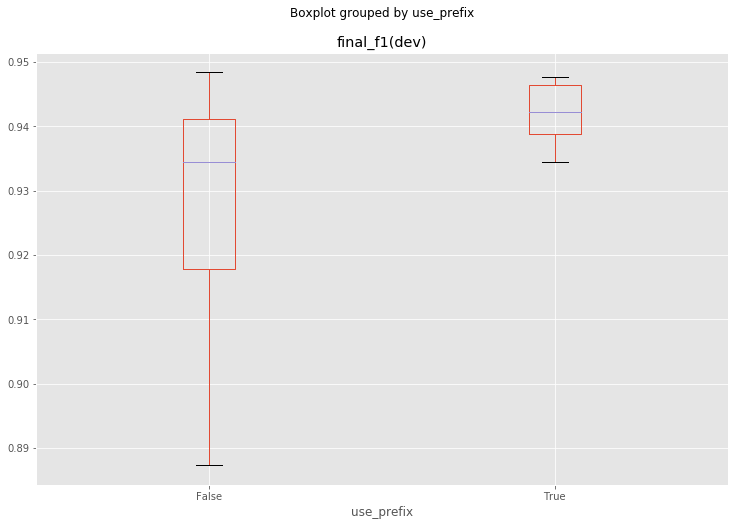

In [45]:
df.boxplot(column='final_f1(dev)', by='use_prefix', figsize=(12, 8))

It seems `use_prefix=True` is better than `use_prefix=False`.

### use_suffix

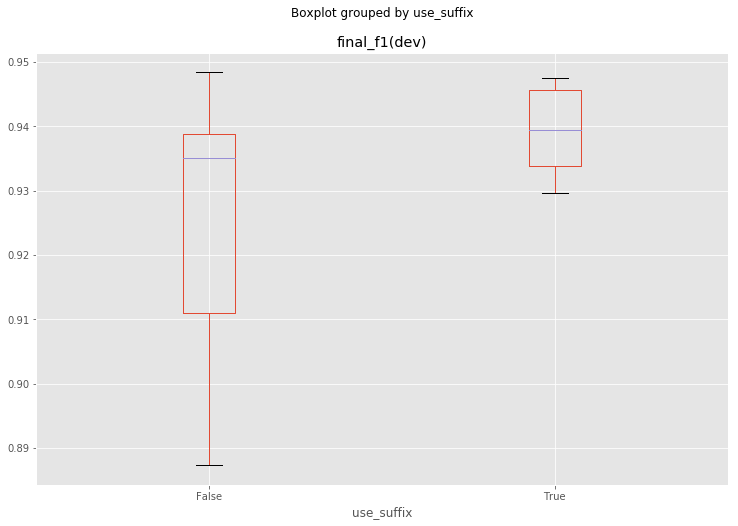

In [46]:
df.boxplot(column='final_f1(dev)', by='use_suffix', figsize=(12, 8))

Likewise, it seems `use_suffix=True` is better than `use_suffix=False`.

### use_wordshape

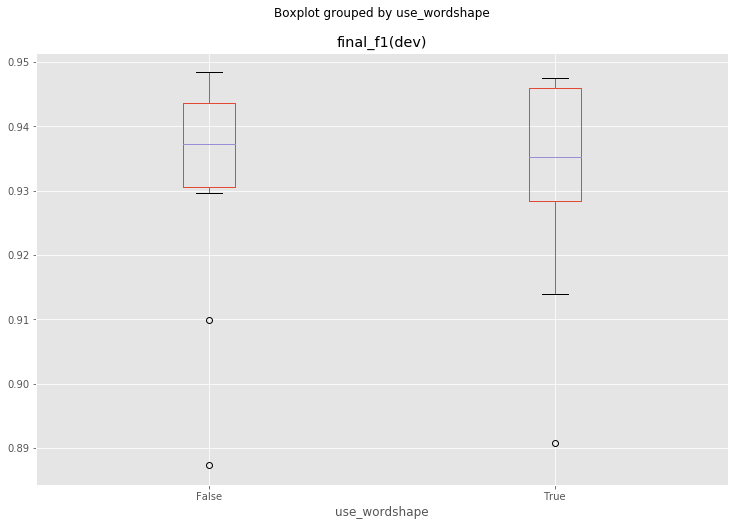

In [47]:
df.boxplot(column='final_f1(dev)', by='use_wordshape', figsize=(12, 8))

A bit unclear, but it seems not using wordshape yields better performance on dev set, though sometimes the performance drops quite low.

## Analyzing categorical (non-binary) variables

### min_freq

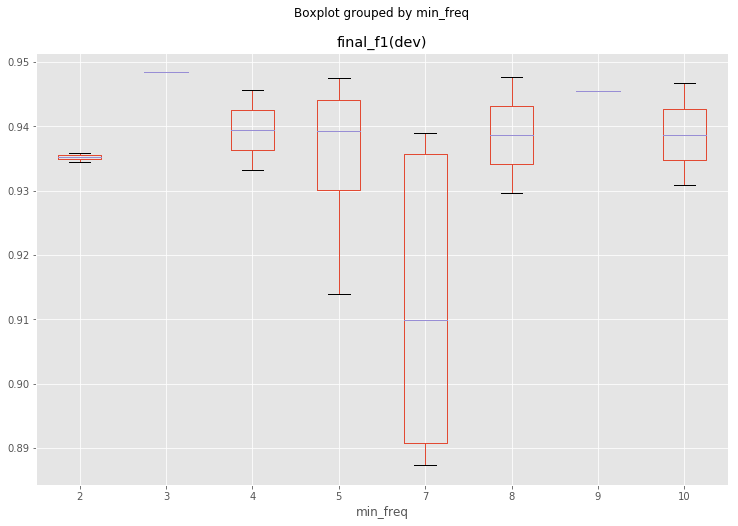

In [48]:
df.boxplot(column='final_f1(dev)', by='min_freq', figsize=(12, 8))

It seems the best range for `min_freq` is between 1 and 5 (inclusive).

### window

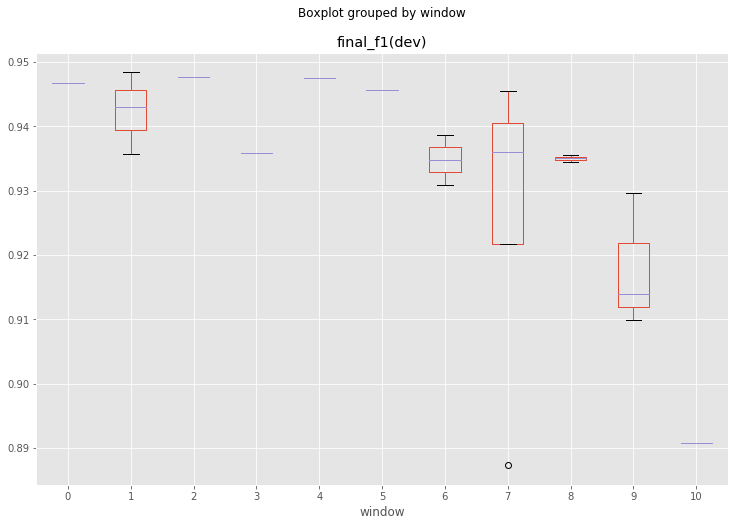

In [49]:
df.boxplot(column='final_f1(dev)', by='window', figsize=(12, 8))

The trend is clear; the higher the window size, the lower the performance becomes. It seems the performance drops significantly when `window=6` and larger. Thus, the best range for `window` seems between 0 and 5 (inclusive).

## Analyzing numerical variables

### c2 on log-scale

In [55]:
df['log_c2'] = np.log10(df.c2)

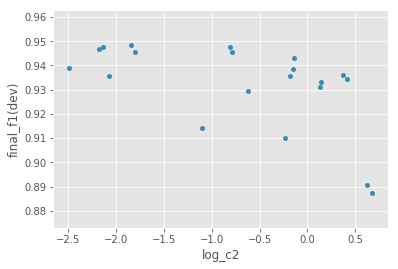

In [56]:
df.plot.scatter(x='log_c2', y='final_f1(dev)')

The trend is not so clear, but larger values of `log_c2` seems detrimental to performance. Thus, it might be wise to set the range for `log_c2` to be [-3, 0].